In [1]:
# Scientific libraries
import numpy as np
import scipy.stats as stats
import scipy.special as sf
import scipy.integrate as integrate
import scipy.interpolate as interpolate

# import Pandas

import pandas as pd
import astropy.io.fits as fits
import astropy.units as u
import astropy.constants as const
from astropy.coordinates import SkyCoord, CartesianRepresentation, ICRS, GCRS,UnitSphericalRepresentation
# Graphic libraries

import matplotlib.pyplot as plt
%matplotlib notebook
from jupyterthemes import jtplot
#plt.style.use('mike_dark') 
jtplot.style(context='notebook', fscale=1, grid=False)

from glob import glob
import copy
import collections
#import warnings
#warnings.simplefilter('ignore')
from pyipn.io.plotting.projection import *

from pyipn.geometry import Location
from pyipn.io.plotting.spherical_circle import SphericalCircle
import stan_utility

green = "#1DEBA6"
red = "#FF0059"
yellow = "#F6EF5B"
from mpl_toolkits.mplot3d import Axes3D 

from pyipn import copy_template, Universe

[0.         0.46060308]


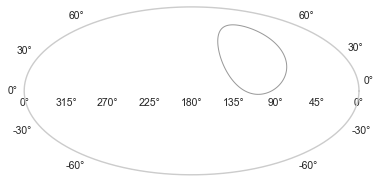

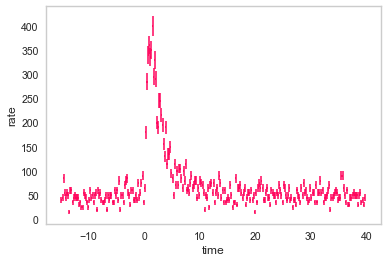

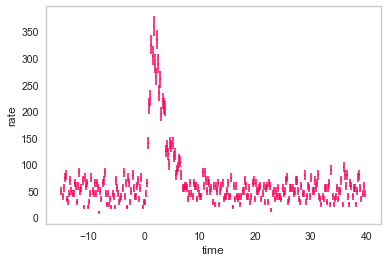

In [2]:

uni = Universe.from_yaml('template_config.yaml')
uni.explode_grb(tstart=-50,tstop=100)
print(uni._T0)
uni.plot_all_annuli(cmap='Set1_r',lw=1);
for det, lc in uni.light_curves.items():

    lc.display(-15,40,.2,color=red)

    
d1 = uni.detectors['det1']
d2 = uni.detectors['det2']

xyz1=d1.location.get_cartesian_coord().xyz.value

xyz2= d2.location.get_cartesian_coord().xyz.value




In [3]:
uni._time_differences

array([0.        , 0.46060308])

In [4]:
lc = uni.light_curves['det1']
counts, times = lc.get_binned_light_curve(-10.,30.,.2)
mid = np.mean([times[:-1],times[1:]], axis=0)
width = times[1:] - times[:-1]




lc2 = uni.light_curves['det2']

counts2, times2 = lc2.get_binned_light_curve(-10,30,.2)
mid2 = np.mean([times2[:-1],times2[1:]], axis=0)
width2 = times2[1:] - times2[:-1]
k=50
k2=25
N_model = 200

predict_time = np.linspace(-20,40,N_model)
omega=np.random.randn(k)
omega2=np.random.randn(k2)


data = dict(N1=len(counts),
            time1=mid,
            counts1=counts.astype(int),
            exposure1=width,
            exposure2=width2,
            N2=len(counts2),
            time2=mid2,
            counts2=counts2.astype(int),
            k=k,
            k2=k2,
            bw=.7,
            omega=omega,
             omega2=omega2,
            N_model=N_model,
            predict_time=predict_time,
            
            sc_pos1 = xyz1,
            sc_pos2 = xyz2,
           
           
           
           )

In [5]:
uni._time_differences

array([0.        , 0.46060308])

In [6]:
model = stan_utility.compile_model('rff_loc.stan', model_name='rff')
#model = stan_utlity.compile_model('loc_mix.stan', model_name='loc_mix')
#model = stan_utility.compile_model('gp_light_curve.stan', model_name='gplc')

Using cached StanModel


In [8]:
fit = model.sampling(warmup=50,iter=100,data=data, chains=4, seed=1234,
                     control = dict(max_treedepth=13, adapt_delta=.9))

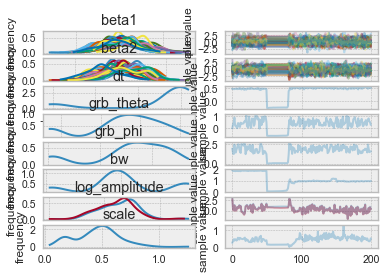

In [9]:
with plt.style.context('bmh'):
    fit.plot(['beta1','beta2',
              'dt',
              'grb_theta',
              'grb_phi',
              'bw',
              'log_amplitude',
              'scale'

             ]);

In [10]:
nondivs, divs = stan_utility.utils.partition_div(fit)





In [11]:
divs.keys()

dict_keys(['log_scale', 'grb_xyz', 'beta1', 'log_bkg', 'expected_count1', 'fhat2', 'scale', 'log_bw', 'grb_phi', 'log_amplitude', 'bkg', 'dt', 'expected_count2', 'grb_theta', 'bw', 'fhat1', 'beta2'])

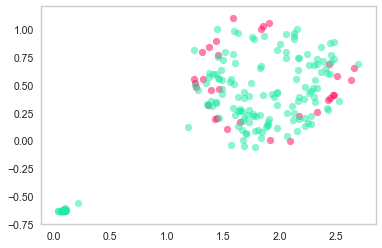

In [12]:
fig, ax = plt.subplots()

ax.scatter(divs['grb_phi'], divs['grb_theta'], color=red,alpha=0.5)
ax.scatter(nondivs['grb_phi'], nondivs['grb_theta'], color=green,alpha=0.5)



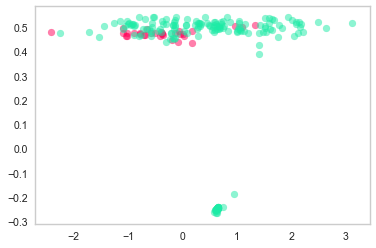

In [13]:
fig, ax = plt.subplots()

ii = 10

ax.scatter(divs['beta2'][:,ii], divs['dt'], color=red, alpha=0.5)
ax.scatter(nondivs['beta2'][:,ii], nondivs['dt'], color=green, alpha=0.5)




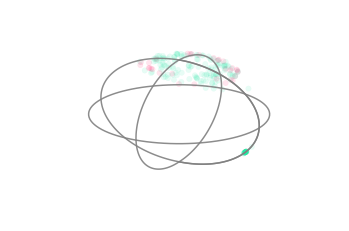

In [14]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
xyz = nondivs['grb_xyz']


R=1

ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],c=green,alpha=.1,s=30, marker='o')

xyz = divs['grb_xyz']


R=1

ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],c=red,alpha=.1,s=30, marker='o')



u1 = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x2 = R * np.outer(np.cos(u1), np.sin(v))
y2 = R * np.outer(np.sin(u1), np.sin(v))
z2 = R * np.outer(np.ones(np.size(u1)), np.cos(v))



ax.plot_wireframe(x2, y2, z2, color="grey", alpha=0.9, rcount=4, ccount=2)


ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax._axis3don = False
ax.pbaspect = [1.0, 1.0, 1.]


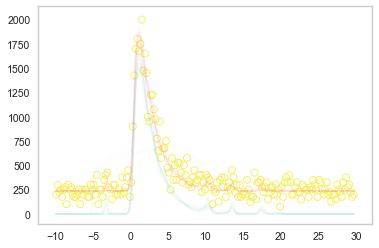

In [15]:
fig, ax = plt.subplots()

fhat = fit.extract("fhat1")["fhat1"]
bkg = fit.extract("bkg")["bkg"][:,1]

for y, b in zip(fhat[::10], bkg[::10]):

    ax.plot(mid, y, alpha=0.01, color=green)
    ax.plot(mid, (y + b), alpha=0.01, color=red)
#    ax.plot(mid,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts/width, edgecolor=yellow, facecolor="none", lw=0.9)

(array([ 7., 23.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  4.,  6., 34., 34., 36., 36., 17.]),
 array([-0.26772296, -0.25148631, -0.23524967, -0.21901303, -0.20277638,
        -0.18653974, -0.1703031 , -0.15406645, -0.13782981, -0.12159317,
        -0.10535652, -0.08911988, -0.07288324, -0.05664659, -0.04040995,
        -0.0241733 , -0.00793666,  0.00829998,  0.02453663,  0.04077327,
         0.05700991,  0.07324656,  0.0894832 ,  0.10571984,  0.12195649,
         0.13819313,  0.15442977,  0.17066642,  0.18690306,  0.2031397 ,
         0.21937635,  0.23561299,  0.25184964,  0.26808628,  0.28432292,
         0.30055957,  0.31679621,  0.33303285,  0.3492695 ,  0.36550614,
         0.38174278,  0.39797943,  0.41421607,  0.43045271,  0.44668936,
         0.462926  ,  0.47916264,  0.49539929,  0.51163593,

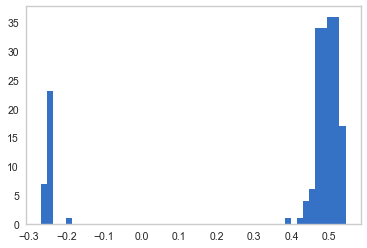

In [16]:
fig, ax = plt.subplots()

dt = fit.extract('dt')['dt']


ax.hist(dt,bins=50)

ValueError: No parameter ppc2

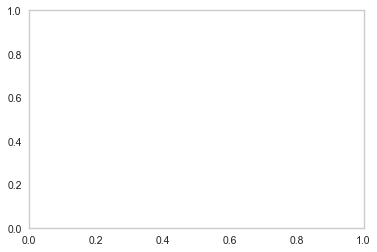

In [17]:
fig, ax = plt.subplots()

ppc2 = fit.extract('ppc2')['ppc2']


for p in ppc2[::10]:

    ax.scatter(mid2,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid2, counts2, edgecolor=red, facecolor='none',lw=.9)

In [ ]:
fig, ax = plt.subplots()

ppc1 = fit.extract('ppc1')['ppc1']


for p in ppc1[::10]:

    ax.scatter(mid,p, alpha=0.025,  edgecolor=yellow, facecolor='none',lw=.9)
   
#    ax.plot(mid2,[b]*len(mid), alpha=0.01, color="k")


ax.scatter(mid, counts, edgecolor=red, facecolor='none',lw=.9)

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection='astro globe',
                                       center=SkyCoord(105,20,unit='deg') ))

theta = np.rad2deg(fit.extract('grb_theta')['grb_theta'])
phi = np.rad2deg(fit.extract('grb_phi')['grb_phi'])



idx = phi <= 0

phi[idx] +=360


ax.scatter(phi, theta, c=green, alpha=.1,transform=ax.get_transform("icrs"),s=20)
ax.scatter(np.array([110.]),np.array([-3.]),c=red, s=40,transform=ax.get_transform("icrs"))



In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
xyz = fit.extract('grb_xyz')['grb_xyz']


R=1

ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2],c=green,alpha=.05)

u1 = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)
x2 = R * np.outer(np.cos(u1), np.sin(v))
y2 = R * np.outer(np.sin(u1), np.sin(v))
z2 = R * np.outer(np.ones(np.size(u1)), np.cos(v))



ax.plot_wireframe(x2, y2, z2, color="grey", alpha=0.9, rcount=4, ccount=2)


ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)
ax._axis3don = False



In [86]:

def compute_annulus_from_time_delay(time_delay, detector1, detector2, ax =None ,color=green,**kwargs):
    
    dxyz = (  detector2.location.get_cartesian_coord().xyz - detector1.location.get_cartesian_coord().xyz)
            
    dcart = Location(
    SkyCoord(
        x=dxyz[0],
        y=dxyz[1],
        z=dxyz[2],
        representation_type="cartesian",
        unit="km",
     #   frame='icrs'
    )
        )
    
    
    norm_d = dcart.get_norm_vec(u.km)
    
    distance = np.linalg.norm(dxyz) * u.km
    
    theta = np.arccos(
            np.around(((-const.c * time_delay*u.s ).to('km')/ distance).value, 15)
        )
    
    
    ra = dcart.coord.represent_as(UnitSphericalRepresentation).lon
    dec = dcart.coord.represent_as(UnitSphericalRepresentation).lat
    
    
    if ax is None:
        fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))
    
    circle = SphericalCircle(
            np.array([ra.value, dec.value]) * ra.unit,
            theta*u.rad,
            vertex_unit=u.deg,
            resolution=5000,
            edgecolor=color,
            facecolor="none",
            transform=ax.get_transform("icrs"),
        **kwargs
       
  
        )
    
    
   
    
    ax.add_patch(circle)
    
    
    
    
    
    
    
    
    
    
    
    
    
    

In [87]:


for d in dt[::20]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax )
    
    
    
ax.scatter(np.array([105.]),np.array([20.]),c=red, s=40,transform=ax.get_transform("icrs"))



TypeError: get_transform() takes 1 positional argument but 2 were given

In [42]:
fig2 = uni.plot_all_annuli(lw=3);


ax2 = fig2.get_axes()[0]
ax2.scatter(np.array([1.]),np.array([10.]),c=yellow, s=40,
            transform=ax.get_transform("icrs")
           )


for d in dt[::20]:

    compute_annulus_from_time_delay(d, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax2 )
    
    


<IPython.core.display.Javascript object>

TypeError: get_transform() takes 1 positional argument but 2 were given

In [43]:
fig, ax = plt.subplots(subplot_kw=dict(projection='astro degrees mollweide'))


compute_annulus_from_time_delay(1.9, detector1=uni.detectors['det1'], detector2=uni.detectors['det2'], ax = ax )
    
   

<IPython.core.display.Javascript object>

/home/jburgess/.venv/pyipn/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in arccos
/home/jburgess/.venv/pyipn/lib/python3.6/site-packages/astropy-3.2.1-py3.6-linux-x86_64.egg/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/jburgess/.venv/pyipn/lib/python3.6/site-packages/astropy-3.2.1-py3.6-linux-x86_64.egg/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/home/jburgess/.venv/pyipn/lib/python3.6/site-packages/astropy-3.2.1-py3.6-linux-x86_64.egg/astropy/coordinates/angles.py:642: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/home/jburgess/.venv/pyipn/lib/python3.6/site-packages/astropy-3.2.1-py3.6-linux-x86_64.egg/astropy/coordinates/angles.

ValueError: The first element of 'code' must be equal to 'MOVETO' (1)

In [ ]:
uni._T0